In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve

import lightgbm as lgb
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier

import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import shap
import missingno as msno

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
accuracy= []
recall =[]
roc_auc= []
precision = []
data = pd.read_csv("./data/02_feature_selected_XGB.csv")

data.rename(columns ={'total_transactions_(including_tnx_to_create_contract':'total_transactions'}, inplace=True)
data.rename(columns ={'ERC20_most_sent_token_type_blockwell.ai KYC Casper Token':'ERC20_sent_blockwellKYCCasper'}, inplace=True)
data.rename(columns ={'ERC20_most_rec_token_type_Blockwell say NOTSAFU':'ERC20_sent_blockwellsayNOTSAFU'}, inplace=True)
data.rename(columns ={'ERC20_most_rec_token_type_Free BOB Tokens - BobsRepair.com':'ERC20_sent_FreeBOBTokens'}, inplace=True)

print(data.columns)

feature_cols = [col for col in data.columns if col not in ['Address', 'FLAG']]
X = data[feature_cols]
y = data['FLAG']

Index(['Address', 'FLAG', 'Avg_min_between_sent_tnx',
       'Avg_min_between_received_tnx',
       'Time_Diff_between_first_and_last_(Mins)', 'Sent_tnx',
       'Unique_Received_From_Addresses', 'Unique_Sent_To_Addresses',
       'min_value_received', 'max_value_received', 'avg_val_received',
       'min_val_sent', 'total_transactions', 'total_ether_received',
       'Total_ERC20_tnxs', 'ERC20_total_Ether_received',
       'ERC20_total_ether_sent', 'ERC20_uniq_sent_addr', 'ERC20_uniq_rec_addr',
       'ERC20_uniq_rec_contract_addr', 'ERC20_min_val_rec',
       'ERC20_max_val_rec', 'ERC20_avg_val_rec', 'ERC20_min_val_sent',
       'ERC20_max_val_sent', 'ERC20_avg_val_sent',
       'ERC20_uniq_sent_token_name', 'ERC20_uniq_rec_token_name',
       'ERC20_most_sent_token_type_ ', 'ERC20_most_sent_token_type_BAT',
       'ERC20_most_sent_token_type_Golem',
       'ERC20_most_sent_token_type_Livepeer Token',
       'ERC20_most_sent_token_type_None',
       'ERC20_most_sent_token_type_Reputa

In [4]:
data.describe()

,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,...,ERC20_most_sent_token_type_Livepeer Token,ERC20_most_sent_token_type_None,ERC20_most_sent_token_type_Reputation,ERC20_most_sent_token_type_StatusNetwork,ERC20_most_sent_token_type_Tronix,ERC20_sent_blockwellKYCCasper,ERC20_most_rec_token_type_,ERC20_sent_blockwellsayNOTSAFU,ERC20_sent_FreeBOBTokens,ERC20_most_rec_token_type_Golem
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,30.360939,25.840159,43.845153,523.152481,100.711721,...,0.000915,0.188599,0.002642,0.006199,0.002642,0.013007,0.002134,0.079159,0.003861,0.012804
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,298.621112,263.820410,325.929139,13008.821539,2885.002236,...,0.030229,0.391209,0.051335,0.078491,0.051335,0.113309,0.046148,0.270000,0.062023,0.112432
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,1.000000,0.001000,1.000000,0.426905,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,2.000000,2.000000,0.095856,6.000000,1.729730,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,5.000000,3.000000,2.000000,67.067040,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,9999.000000,9287.000000,10000.000000,800000.000000,283618.831600,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgbcls = XGBClassifier(random_state=0)

xgbcls.fit(X_train, y_train)

y_pred = xgbcls.predict(X_test)

In [6]:
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

In [7]:
model_names = ['XGB_random0']
result_df = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)

In [8]:
result_df

,Accuracy,Recall,Roc_Auc,Precision
XGB_random0,0.9944,0.9785,0.9889,0.9978


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

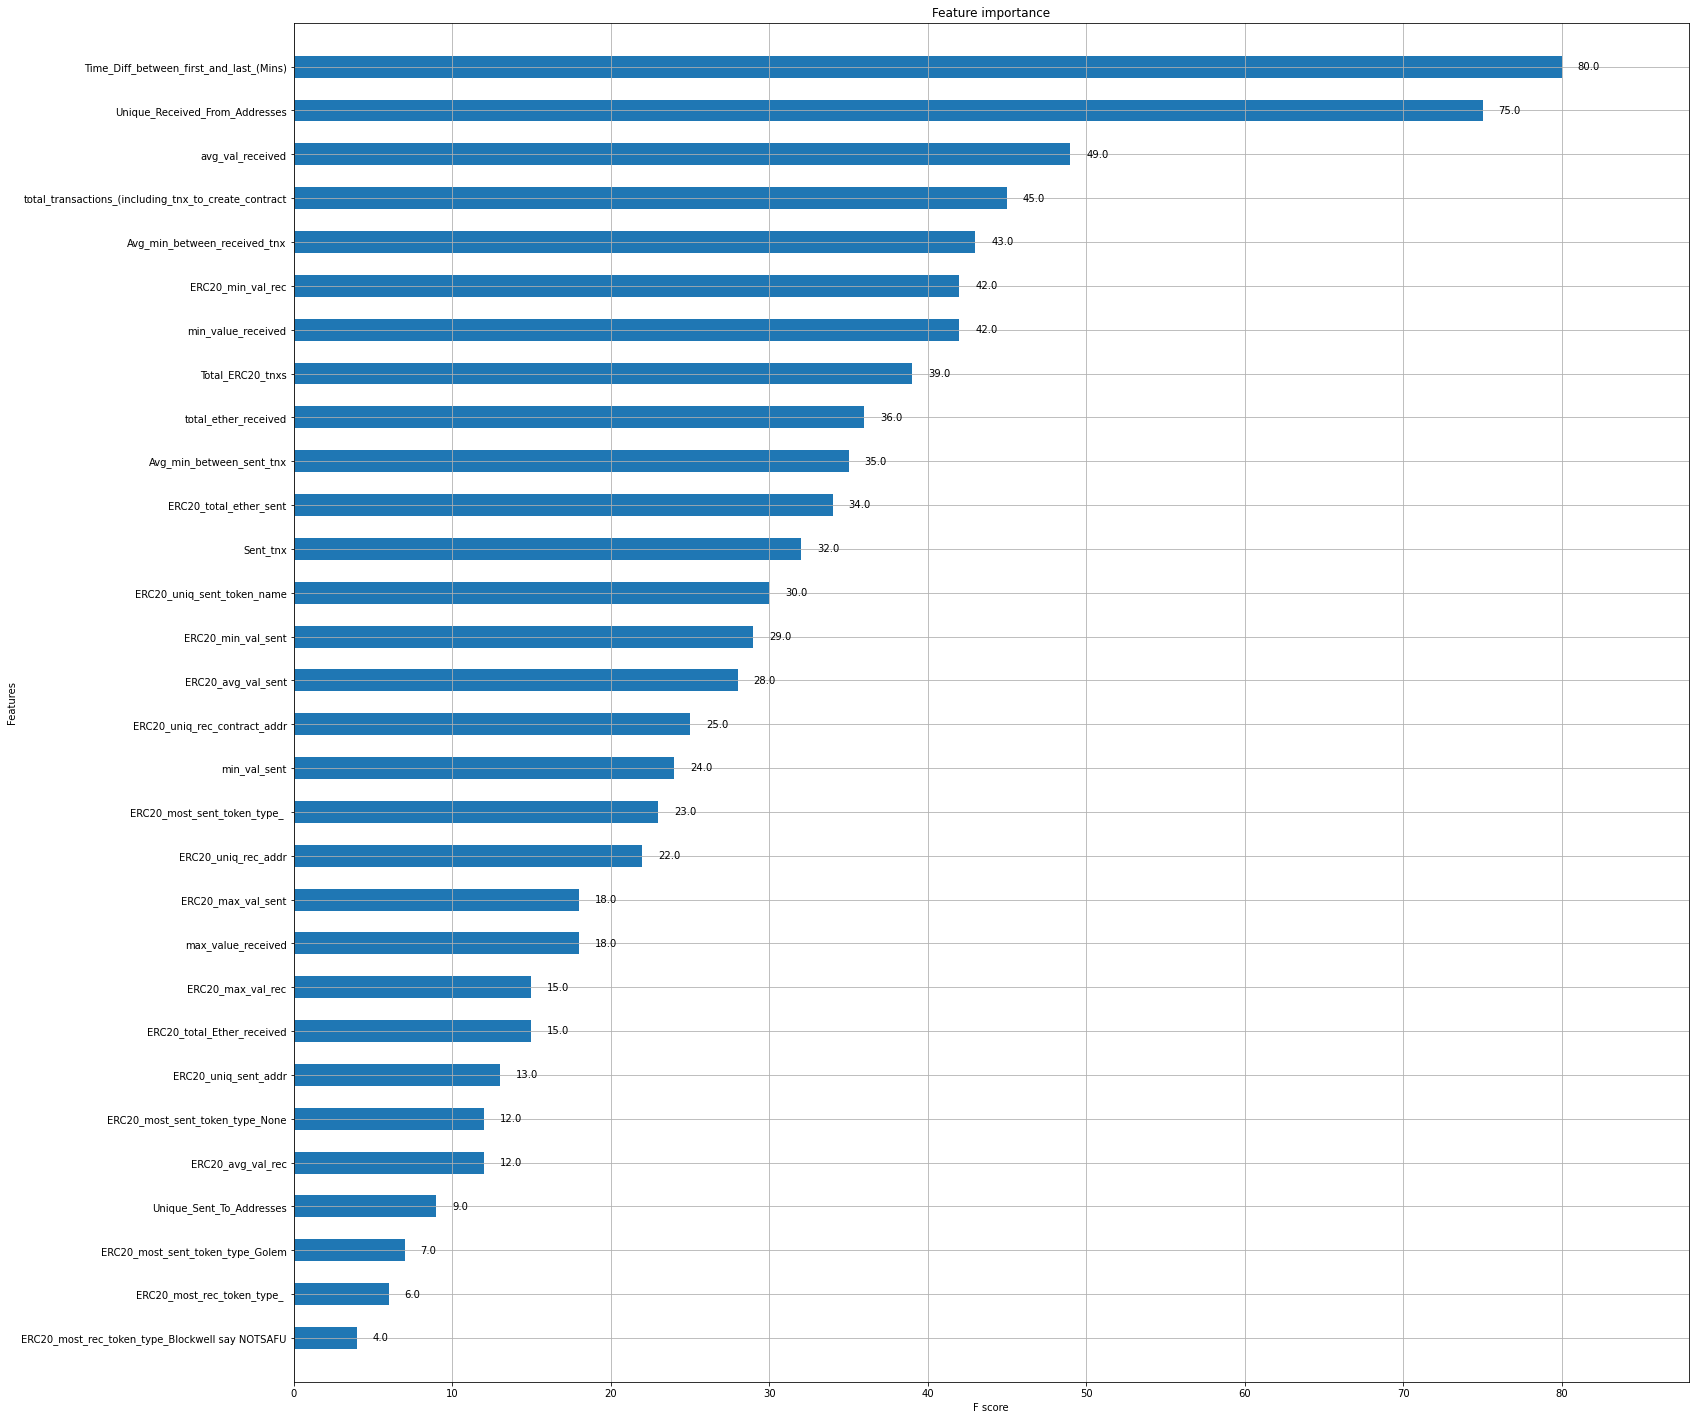

In [8]:
# from xgboost import plot_importance
# fig,ax = plt.subplots(figsize=(25,25))
# plot_importance(xgbcls,height=0.5, ax=ax, max_num_features=30)



In [9]:
explainerXGB = shap.TreeExplainer(xgbcls)

shap_values_XGB_test = explainerXGB.shap_values(X_test)

shap_values_XGB_train = explainerXGB.shap_values(X_train)

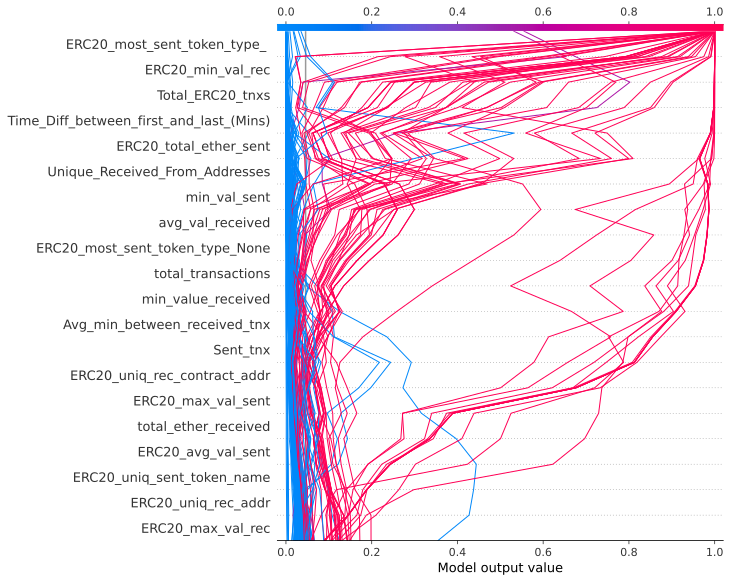

In [12]:
# plt.rcParams['font.sans-serif']=['SimHei']
%config InlineBackend.figure_format = 'svg'

shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[:200], X_test.iloc[:200],link= "logit")


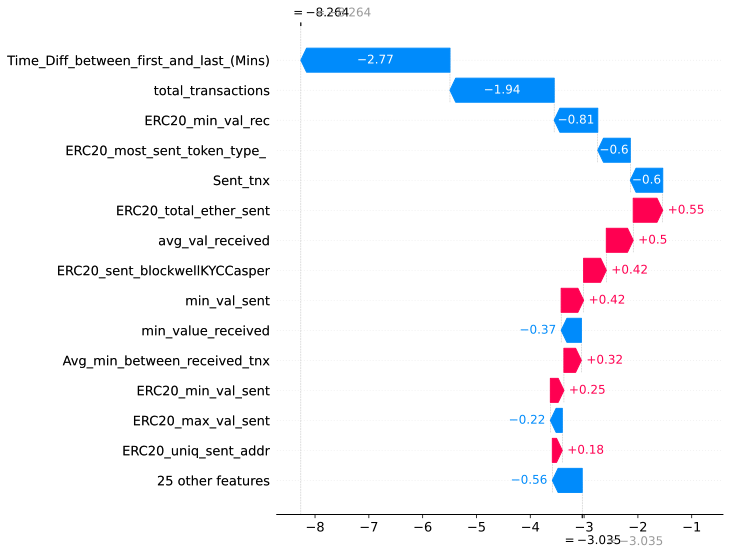

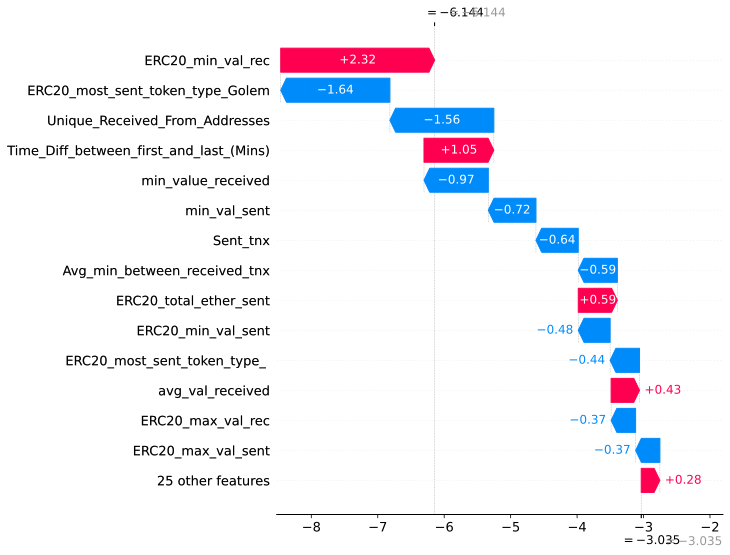

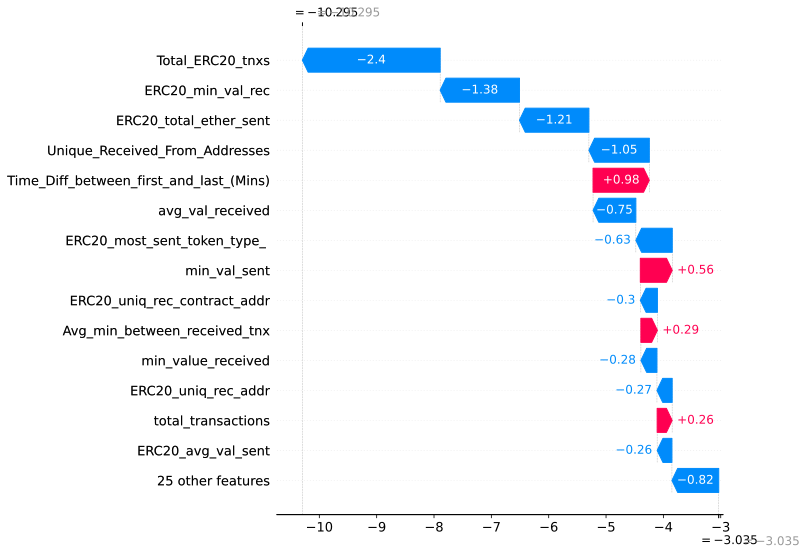

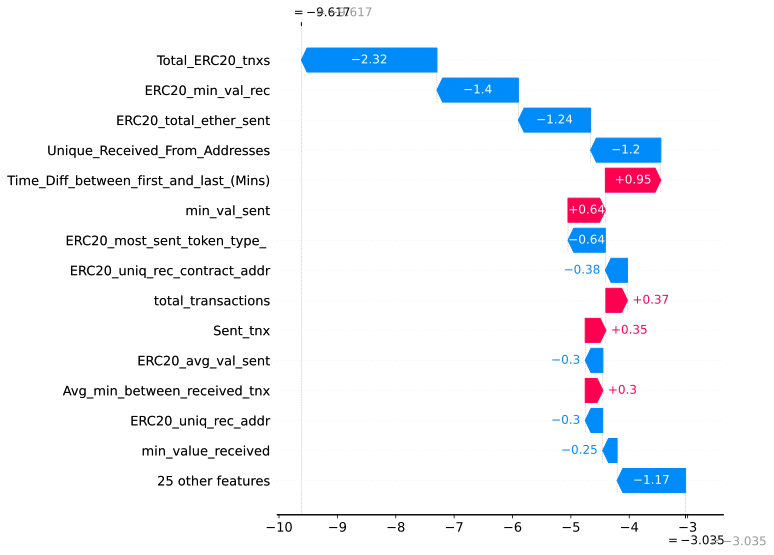

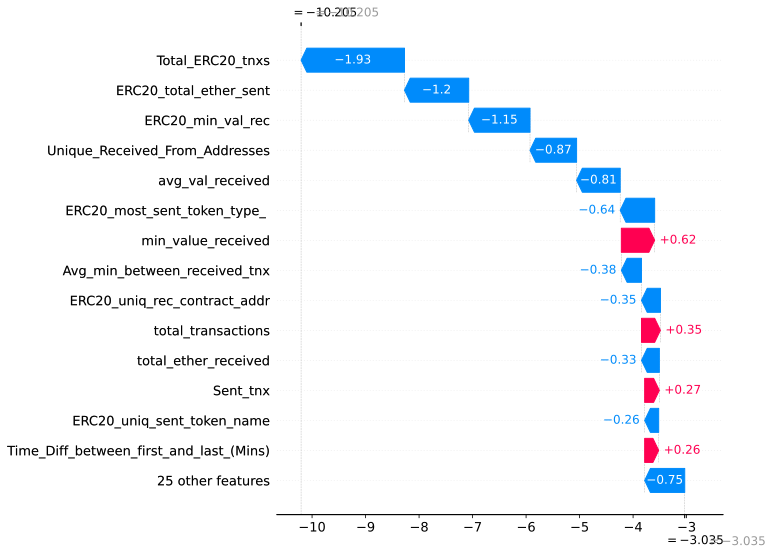

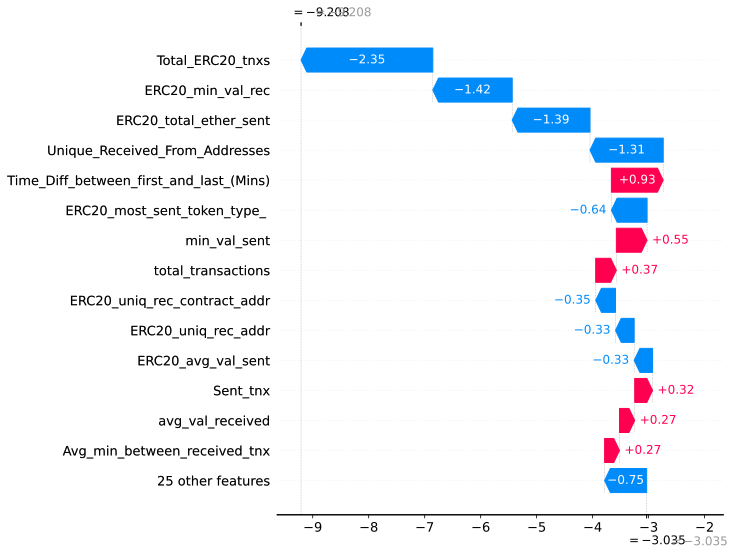

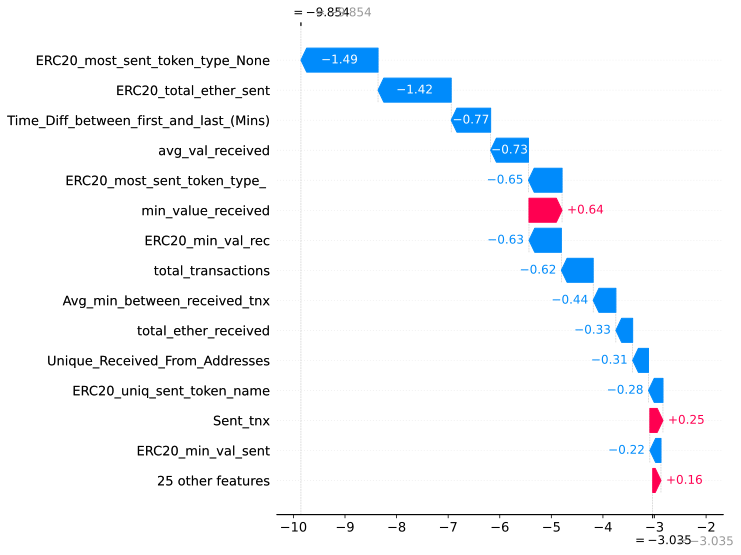

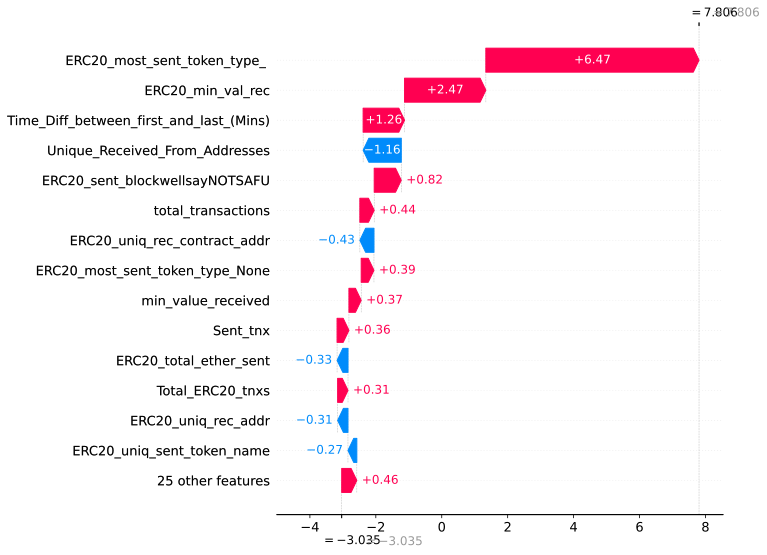

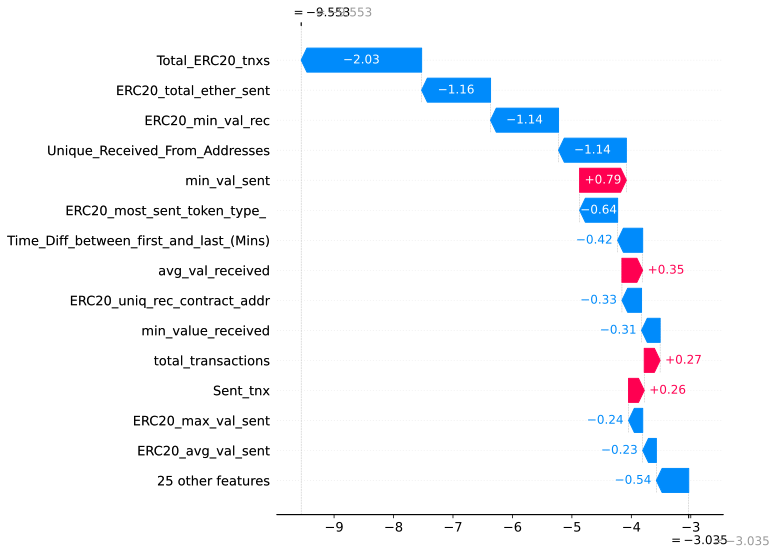

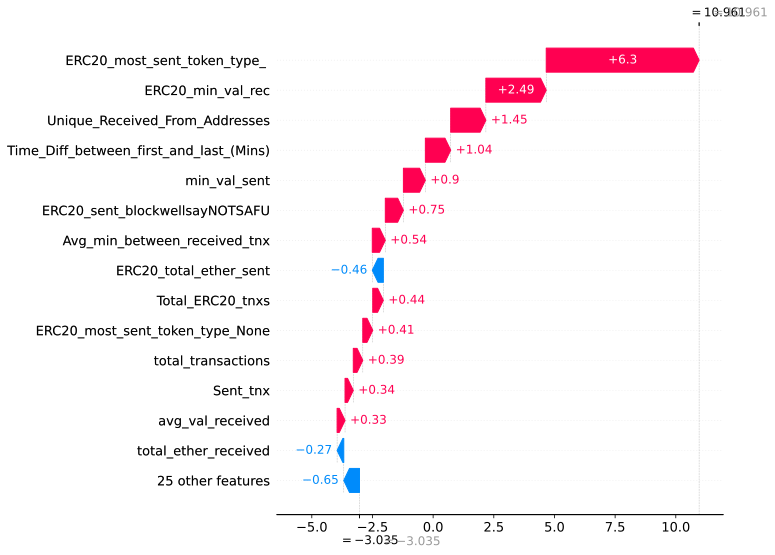

In [15]:
for i in range(10):
    shap.plots._waterfall.waterfall_legacy(explainerXGB.expected_value, shap_values_XGB_test[i], feature_names = X_test.columns, max_display = 15)

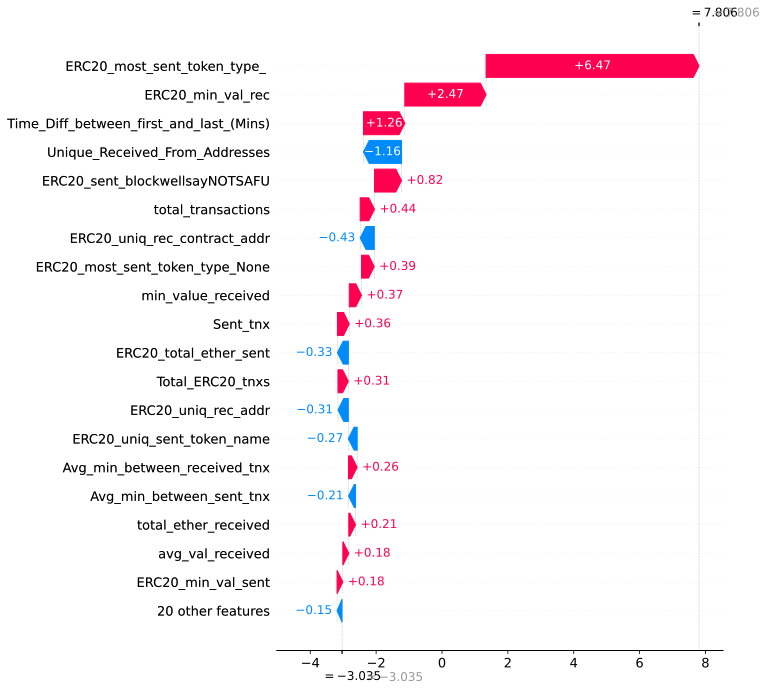

In [23]:
shap.plots._waterfall.waterfall_legacy(explainerXGB.expected_value, shap_values_XGB_test[7], feature_names = X_test.columns, max_display = 20)

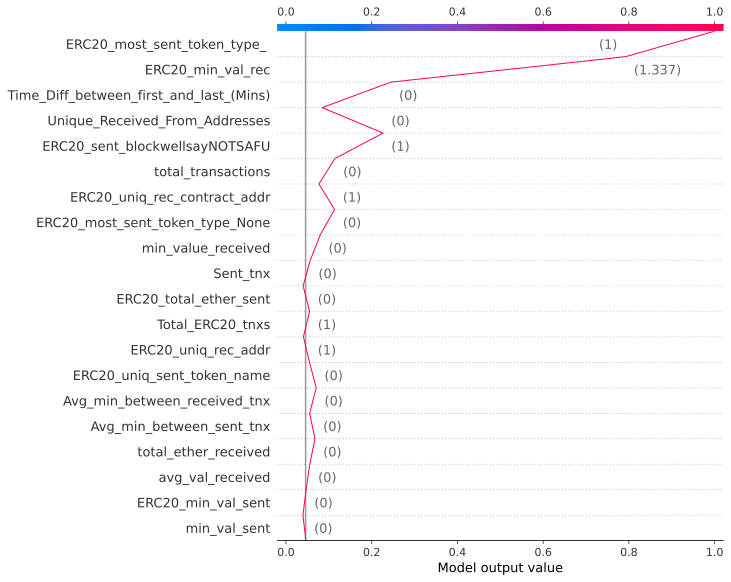

In [24]:
shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[7], X_test.iloc[[7]],link= "logit")

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainerXGB.expected_value, shap_values_XGB_test[0], feature_names = X_test.columns, max_display = 15)

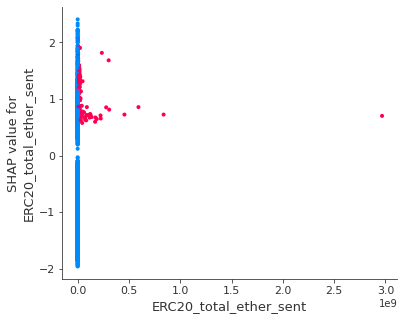

In [10]:
shap.dependence_plot('ERC20_total_ether_sent', shap_values_XGB_train, X_train,  interaction_index='ERC20_total_ether_sent')

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar", max_display=30, plot_size=(12, 12), show=True, cmap=plt.get_cmap('cool'))

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="dot", max_display=30, plot_size=(12,12), cmap=plt.get_cmap('cool'))

In [ ]:
for i in range(20):
    print(i)
    shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[i], X_test.iloc[[i]],link= "logit")

In [ ]:
# plt.rcParams['font.sans-serif']=['SimHei']
%config InlineBackend.figure_format = 'retina'

shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[0], X_test.iloc[[0]],link= "logit")

In [ ]:
%config InlineBackend.figure_format = 'retina'

shap.plots._waterfall.waterfall_legacy(explainerXGB.expected_value, shap_values_XGB_test[0], feature_names = X_test.columns,max_display = 21)

In [ ]:
# plt.rcParams['font.sans-serif']=['SimHei']
%config InlineBackend.figure_format = 'retina'

shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[:200], X_test.iloc[:200],link= "logit")

In [ ]:
# plt.rcParams['font.sans-serif']=['SimHei']
%config InlineBackend.figure_format = 'retina'

shap.plots._waterfall.waterfall_legacy(explainerXGB.expected_value, shap_values_XGB_test[7], feature_names = X_test.columns,max_display = 21)

In [ ]:
shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[11], X_test.iloc[[11]],link= "logit")

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainerXGB.expected_value, shap_values_XGB_test[7], feature_names = X_test.columns, max_display = 30)

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainerXGB.expected_value, shap_values_XGB_test[6], feature_names = X_test.columns, max_display = 30)

In [ ]:
shap.dependence_plot("Unique_Received_From_Addresses", shap_values_XGB_test, X_test, interaction_index=None)

In [ ]:
cols = [col for col in X.columns]
for col in cols:
    shap.dependence_plot(col, shap_values_XGB_train, X_train,  interaction_index=None)

In [ ]:
cols = [col for col in X.columns]
for col in cols:
    shap.dependence_plot(col, shap_values_XGB_train, X_train,  interaction_index='ERC20_min_val_rec')

In [ ]:
cols = [col for col in X.columns]
for col in cols:
    shap.dependence_plot(col, shap_values_XGB_train, X_train,  interaction_index='ERC20_most_sent_token_type_ ')

In [ ]:
cols = [col for col in X.columns]
for col in cols:
    shap.dependence_plot(col, shap_values_XGB_train, X_train,  interaction_index='Total_ERC20_tnxs')

In [ ]:
cols = [col for col in X.columns]
for col in cols:
    shap.dependence_plot(col, shap_values_XGB_train, X_train,  interaction_index='ERC20_total_ether_sent')

In [ ]:
cols = [col for col in X.columns]
for col in cols:
    shap.dependence_plot('Time_Diff_between_first_and_last_(Mins)', shap_values_XGB_train, X_train,  interaction_index=col)

In [ ]:
cols = [col for col in X.columns]
for col in cols:
    shap.dependence_plot('Avg_min_between_received_tnx', shap_values_XGB_train, X_train,  interaction_index=col)